In [138]:
import pandahouse
import numpy as np
import pandas as pd
import hashlib
import seaborn as sns
import scipy.stats as stats

In [139]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

<font size="16">Тест Манна-Уитни поверх бакетного преобразования </font>

In [140]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
'database':'simulator_20230820',
'user':'student',
'password':'dpo_python_2020'
}

In [141]:
q = """
SELECT exp_group,buket,
        sum(likes)/sum(views) as buket_ctr
FROM
(SELECT exp_group, 
    user_id,
    xxHash64(user_id)%75 as buket,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-07-30' and '2023-08-05'
    and exp_group in (1,2)
GROUP BY exp_group, buket,user_id)
GROUP BY exp_group, buket
"""

df = pandahouse.read_clickhouse(q, connection=connection)

<Axes: xlabel='buket_ctr', ylabel='Count'>

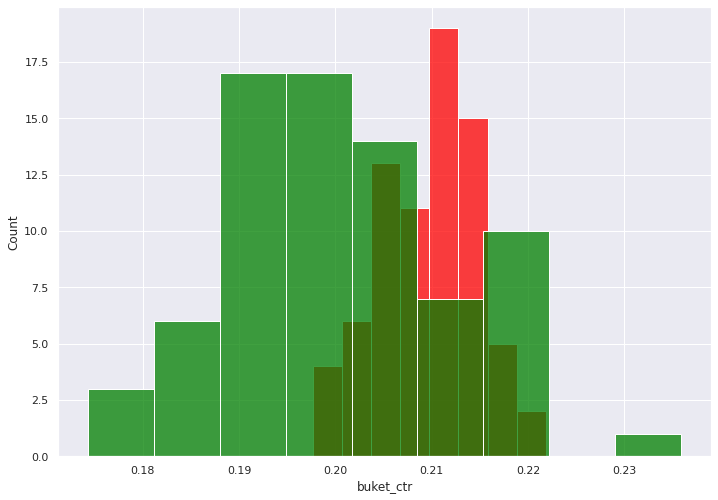

In [142]:
sns.histplot(df[df['exp_group']==1].buket_ctr,color="red")
sns.histplot(df[df['exp_group']==2].buket_ctr,color="green")

In [143]:
stats.mannwhitneyu(df[df['exp_group']==1].buket_ctr,df[df['exp_group']==2].buket_ctr,alternative='two-sided')

MannwhitneyuResult(statistic=4240.0, pvalue=8.153216028601963e-08)

<font size='6' color='DarkSlateBlue'>Тест Манна-Уитни поверх бакетного преобразования показывает p меньше 0.05, т.е. различия между ctr имеются. Судя по диаграмме показатели ctr тестовой группы ниже чем у контрольной. Основная гипотеза об увеличении показателя ctr у второй группы неверна</font>


<font size="16">T test и Тест Манна-Уитни</font>

In [144]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-07-30' and '2023-08-05'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df2 = pandahouse.read_clickhouse(q, connection=connection)

<Axes: xlabel='ctr', ylabel='Count'>

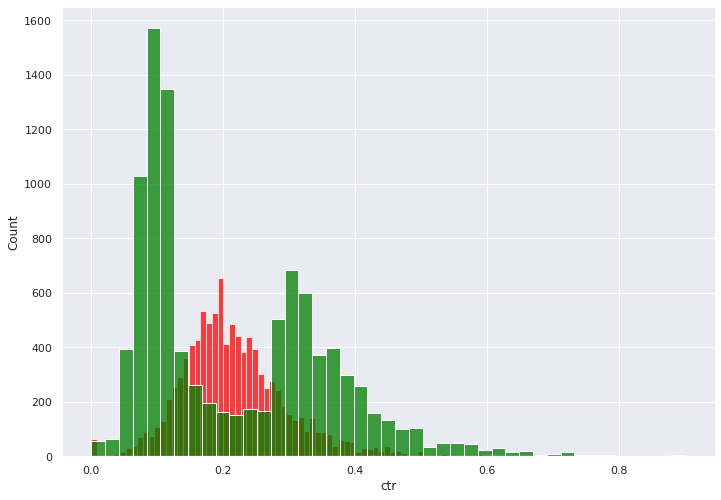

In [145]:
sns.histplot(df2[df2['exp_group']==1].ctr,color="red")
sns.histplot(df2[df2['exp_group']==2].ctr,color="green")

In [146]:
stats.ttest_ind(df2[df2['exp_group']==1].ctr,df2[df2['exp_group']==2].ctr,equal_var=False)

Ttest_indResult(statistic=0.4051491913112757, pvalue=0.685373331140751)

<font size='6' color='DarkSlateBlue'> Т тест показал p>0.05 и не отклонил нулевую гипотезу. Распределение тестовой группы не похоже на нормальное, тк является бимодальным, поэтому применять т тест в данном случае не стоит </font>

In [147]:
stats.mannwhitneyu(df2[df2['exp_group']==1].ctr,df2[df2['exp_group']==2].ctr)

MannwhitneyuResult(statistic=55189913.0, pvalue=4.632205841806026e-45)

<font size='6' color='DarkSlateBlue'> Тест Манна Уитни показал различия между ctr, по диаграмме сложно сказать какой ctr выше(так распределение тестовой группы бимодально),поэтому делаем такой же вывод как в Тесте Манна-Уитни поверх бакетного преобразования </font>

<font size="16">T тест на сглаженном ctr</font>

In [148]:
def get_smoothed_ctr(global_ctr,likes,views,alpha=0.5):
    return (likes+alpha*global_ctr)/(views+alpha)

In [149]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-07-30' and '2023-08-05'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df3 = pandahouse.read_clickhouse(q, connection=connection)

In [150]:
global_ctr1=df3[df3['exp_group']==1].likes.sum()/df3[df3['exp_group']==1].views.sum()
global_ctr2=df3[df3['exp_group']==2].likes.sum()/df3[df3['exp_group']==2].views.sum()

In [151]:
smoothed_ctr1=get_smoothed_ctr(global_ctr1,df3[df3['exp_group']==1].likes,df3[df3['exp_group']==1].views)
smoothed_ctr2=get_smoothed_ctr(global_ctr2,df3[df3['exp_group']==2].likes,df3[df3['exp_group']==2].views)

<Axes: ylabel='Count'>

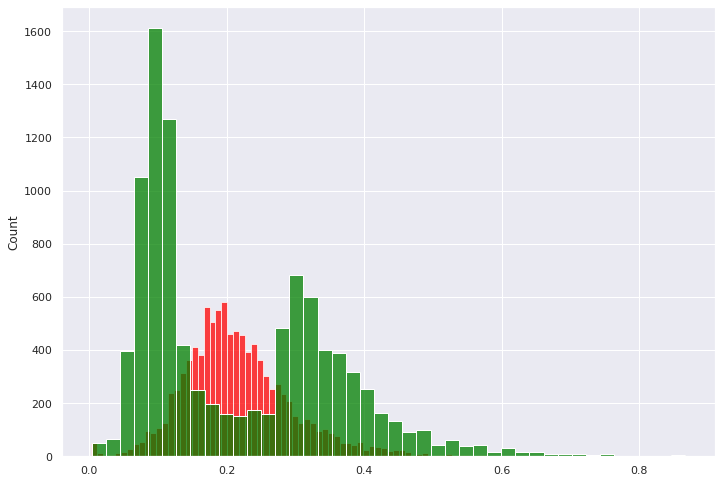

In [152]:
sns.histplot(smoothed_ctr1,color="red")
sns.histplot(smoothed_ctr2,color="green")

In [153]:
stats.ttest_ind(smoothed_ctr1,smoothed_ctr2,equal_var=False)

Ttest_indResult(statistic=0.5822132702627917, pvalue=0.5604313542555932)

<font size='6' color='DarkSlateBlue'> В силу бимодальности тестовго распределения доверять т тесту опять таки не стоит</font>

<font size="16">Пуассоновский бустреп</font>

In [154]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

<Axes: ylabel='Count'>

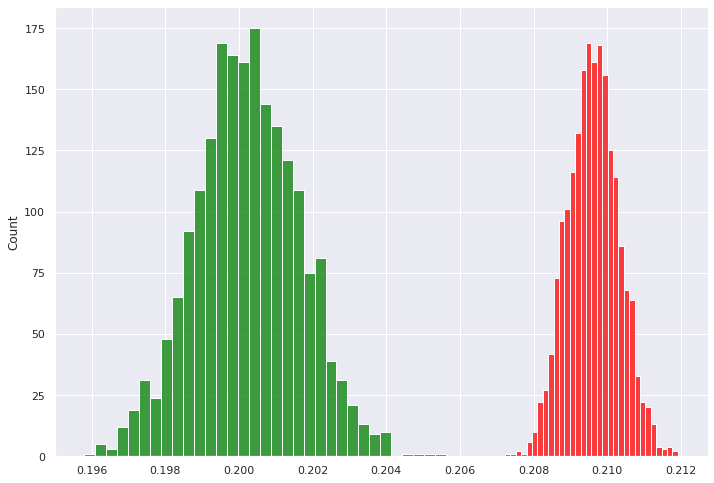

In [155]:
likes1 = df2[df2.exp_group == 1].likes.to_numpy()
views1 = df2[df2.exp_group == 1].views.to_numpy()
likes2 = df2[df2.exp_group == 2].likes.to_numpy()
views2 = df2[df2.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1,color="red")
sns.histplot(ctr2,color="green")

In [157]:
stats.ttest_ind(ctr1,ctr2,equal_var=False)

Ttest_indResult(statistic=266.0558891583224, pvalue=0.0)

<font size='6' color='DarkSlateBlue'> Пуассоновский бустреп показал, что ctr тестовой группы ниже чем у контрольной, что также подтверждается другими тестами </font>

<font size='6' color='DimGrey'> 3: Возможно алгоритм рекомендации постов был написан некорректно, исходя из бимодальности распределения тестовой группы можно предположить, что люди поделились на две группы : у одной группы алгоритм срабатывал корректно и ctr увеличился, у другой срабатывал плохо и пользователю показывались посты, которые ему нравятся меньше, чем посты из обычной ленты, т.е. подбор постов стал хуже чем раньше.   </font>

<font size='6' color='DimGrey'> 4: Исходя из полученных результатов, я не рекомендую вводить новый алгоритм для всех пользователей, так как ctr тестовой группы ниже чем ctr контрольной, то есть основная гипотеза неверна </font>